# Advanced Lane Finding
The Goal of this Project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository.

---
## Camera Calibration with OpenCV


### Extraction of object points and image points for camera calibration.  

Real cameras use curved lenses to form an image, and light rays often bend a little too much or too little at the edges of these lenses. This creates an effect that distorts the edges of images, so that lines or objects appear more or less curved than they actually are. This is called radial distortion, and it’s the most common type of distortion.

Another type of distortion, is tangential distortion. This occurs when a camera’s lens is not aligned perfectly parallel to the imaging plane, where the camera film or sensor is. This makes an image look tilted so that some objects appear farther away or closer than they actually are.

There are three coefficients needed to correct for radial distortion: `k1`, `k2`, and `k3`. To correct the appearance of radially distorted points in an image, one can use a correction formula.
To undistort image, `OpenCV` calculates `r`, which is the known distance between a point in an undistorted (corrected) image and the center of the image distortion, which is often the center of that image. This center point is sometimes referred to as the distortion center. These points are pictured below.

![title](img/dist.png)

I used the OpenCV functions `findChessboardCorners()` and `drawChessboardCorners()` to automatically find and draw corners in an image of a chessboard pattern.

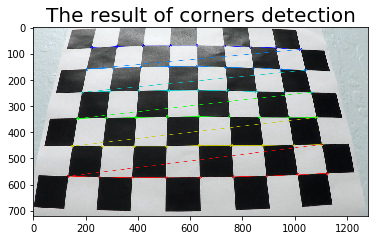

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')
z = len(images)
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if idx == z-1:
            # Draw and display last corner
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            plt.title("The result of corners detection", fontsize=20)
            plt.imshow(img);

### We have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

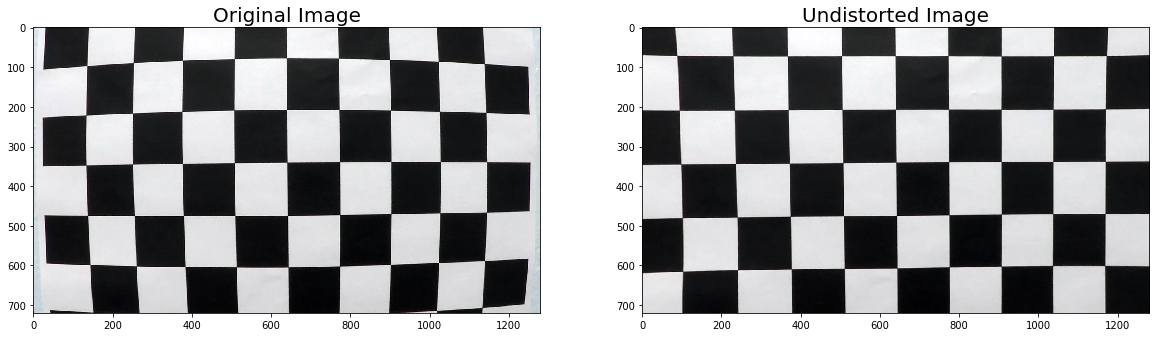

In [2]:
# Test undistortion on an image
test = 'camera_cal/calibration1.jpg'
img = cv2.imread(test)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

def undist_(img, mtx = mtx, dist = dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

dst = undist_(img)
#cv2.imwrite('calibration_test/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20);

### As we see the image becaome less distordered, but still it is not perfect. To improve it we need more calibration images

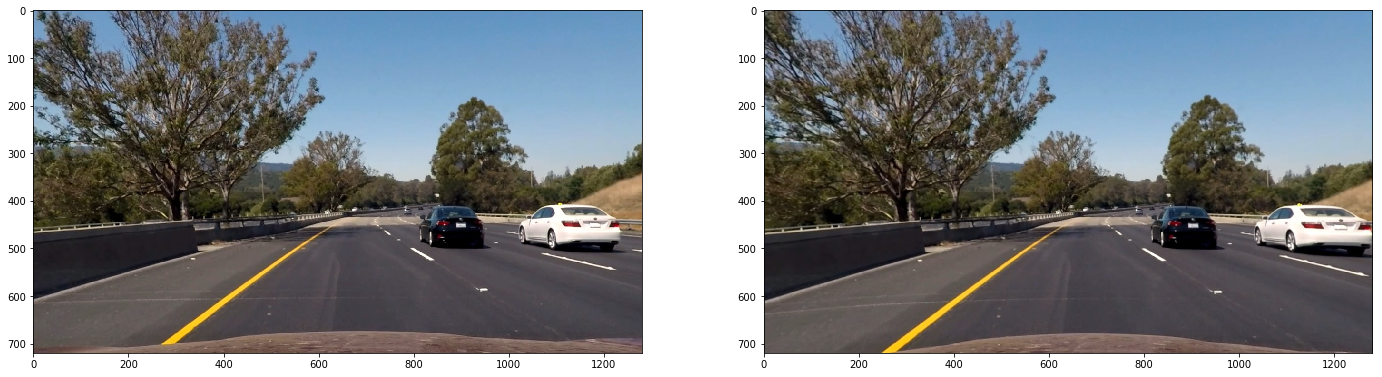

In [3]:
# Load test image
test_images = glob.glob('test_images/*.jpg')
image = undist_(cv2.imread(test_images[6]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
ax1.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(undist_(image),cv2.COLOR_BGR2RGB));

In [4]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #d efining a blank mask to start with
    mask = np.zeros_like(img)
    imshape = img.shape
    vertices = np.array([[(0,450),(0,704),(210,704),(640,660),(1080,693),(imshape[1],680),(imshape[1],450)]],dtype=np.int32)
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
def col_thresh0(img, c_thresh=(120, 255), sobel_kernel = 3):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,0]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= c_thresh[0]) & (s_channel <= c_thresh[1])] = 1
    return s_binary

def col_thresh1(img, c_thresh=(120, 255), sobel_kernel = 3):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,1]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= c_thresh[0]) & (s_channel <= c_thresh[1])] = 1
    return s_binary

def col_thresh2(img, c_thresh=(120, 255), sobel_kernel = 3):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= c_thresh[0]) & (s_channel <= c_thresh[1])] = 1
    return s_binary

def col_thresh3(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Yellow range
    lower_yellow = np.array([15,60,50])
    upper_yellow = np.array([40,255,255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # White range
    lower_white = np.array([0,0,200])
    upper_white = np.array([170,30,255])
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    return cv2.bitwise_or(mask_yellow, mask_white)

def col_thresh4(image):
    result1 = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,2]
    result2 = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0]
    sbinary1 = np.zeros_like(result1)
    sbinary1[(result1 >= 90) & (result1 <= 150)] = 1
    sbinary2 = np.zeros_like(result2)
    sbinary2[(result2 >= 0) & (result2 <= 210)] = 1
    return cv2.bitwise_not(cv2.bitwise_and(sbinary1, sbinary2))

def abs_sobel_thresh(img, orient='x', s_thresh=(0, 255), sobel_kernel = 3):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print("Error")
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= s_thresh[0]) & (scaled_sobel <= s_thresh[1])] = 1
    # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return sbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(direction)
    sbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    
    # Image preprocessing steps:
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

### Color and Gradient Threshold and Image distortion Results

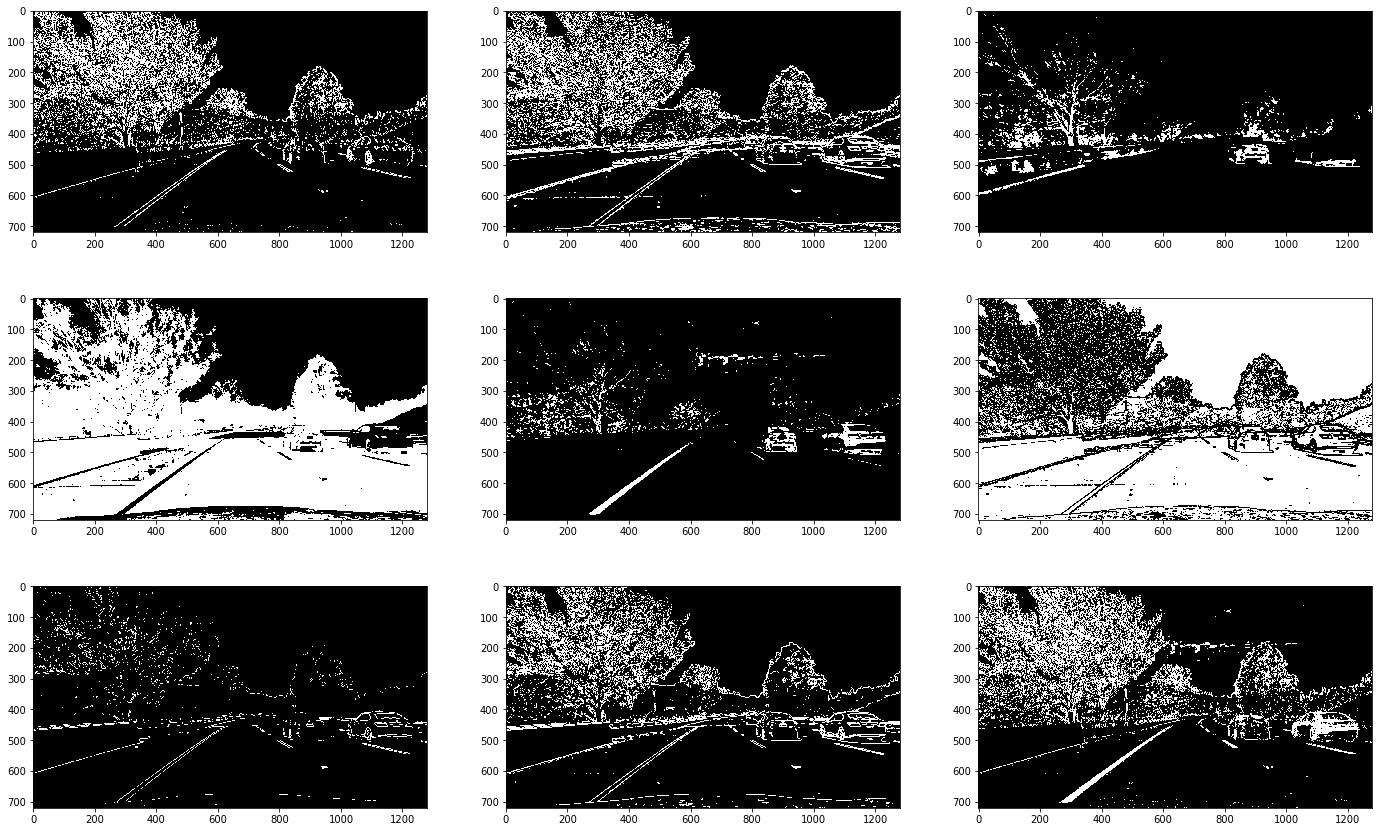

In [6]:
# Load test image
test_images = glob.glob('test_images/*.jpg')
image = undist_(cv2.imread(test_images[6]))

# Color and Gradient Threshold and Image distortion processing
result1 = abs_sobel_thresh(image, orient='x', s_thresh = (15, 255), sobel_kernel = 3)
result2 = abs_sobel_thresh(image, orient='y', s_thresh = (15, 255), sobel_kernel = 3)
result3 = col_thresh1(image, c_thresh=(1, 30), sobel_kernel = 3)
result4 = col_thresh1(image, c_thresh=(1, 100), sobel_kernel = 3)
result5 = col_thresh2(image, c_thresh=(120, 255), sobel_kernel = 3)
result6 = mag_thresh(image, mag_thresh=(0, 11), sobel_kernel=3)
result7 = mag_thresh(image, mag_thresh=(70, 255), sobel_kernel=3)
result8 = mag_thresh(image, mag_thresh=(30, 255), sobel_kernel=1)

# Plot the result
f, ((ax1, ax2, ax3),(ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(24, 15))
ax1.imshow(result1, cmap='gray')
ax2.imshow(result2, cmap='gray')
ax3.imshow(result3, cmap='gray')
ax4.imshow(result4, cmap='gray')
ax5.imshow(result5, cmap='gray')
ax6.imshow(result6, cmap='gray')
ax7.imshow(result7, cmap='gray')
ax8.imshow(result8, cmap='gray')

combined_binary = np.zeros_like(result1)
combined_binary[((result5 == 1) & (result3 == 0)) | (result1 == 1)] = 1

ax9.imshow(combined_binary, cmap='gray');

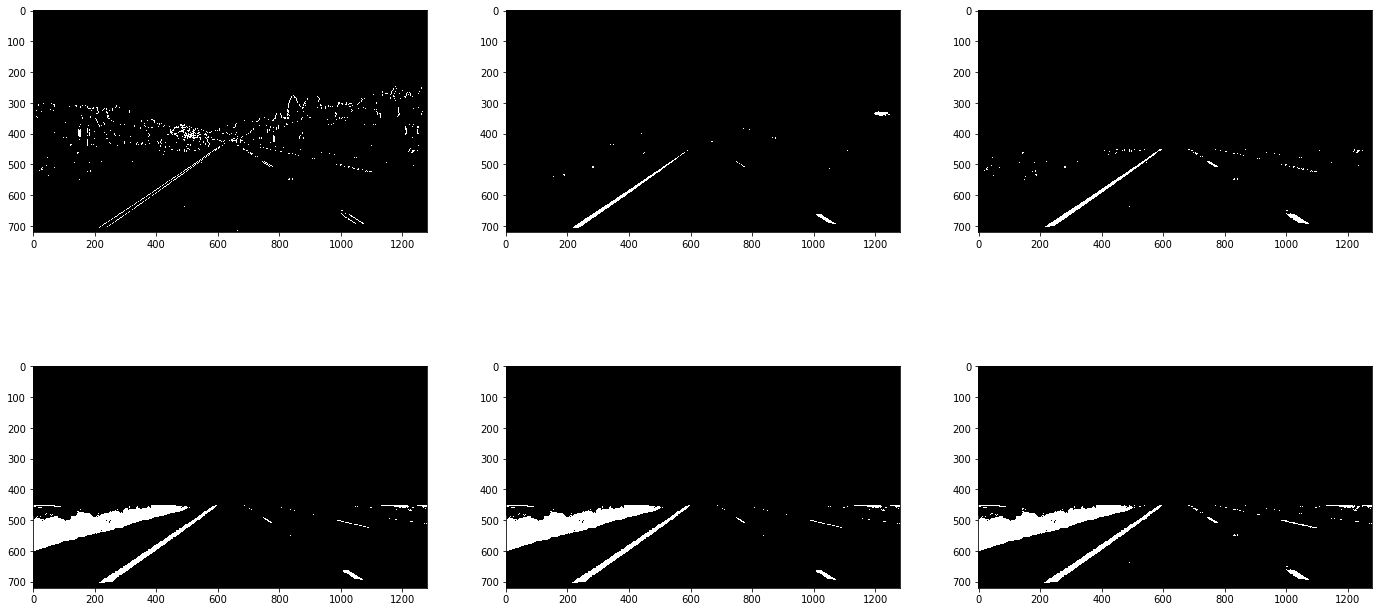

In [7]:
# Load test image
test_images = glob.glob('test_images/*.jpg')
image = undist_(cv2.imread(test_images[7]))

# Color and Gradient Threshold and Image distortion processing
result1 = abs_sobel_thresh(image, orient='x', s_thresh = (40, 255), sobel_kernel = 3)
result4 = col_thresh1(image, c_thresh=(0, 100), sobel_kernel = 3)
result5 = col_thresh2(image, c_thresh=(120, 255), sobel_kernel = 3)
mask = col_thresh3(image)
mask = np.uint8(mask/np.max(mask))

result1 = b = np.uint8(result1/np.max(result1))
a = cv2.bitwise_and(cv2.bitwise_not(cv2.bitwise_and(result4, result5)), result5)
a = np.uint8(a/np.max(a))
b = cv2.bitwise_or(np.uint8(a), result1)
b = np.uint8(b/np.max(b))
            
c = cv2.bitwise_or(a, mask)
d = cv2.bitwise_or(b, mask)

# Plot the result
f, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(24, 12))
ax1.imshow(result1, cmap='gray')

ax2.imshow(a, cmap='gray')
ax3.imshow(region_of_interest(b), cmap='gray')
ax4.imshow(region_of_interest(mask), cmap='gray')
ax5.imshow(region_of_interest(c), cmap='gray')
ax6.imshow(region_of_interest(d), cmap='gray');

In [8]:
def pipline_(image):
    # Color and Gradient Threshold and Image distortion processing
    result1 = abs_sobel_thresh(image, orient='x', s_thresh = (40, 255), sobel_kernel = 3)
    result1 = np.uint8(result1/np.max(result1))
    result4 = col_thresh1(image, c_thresh=(0, 100), sobel_kernel = 3)
    result5 = col_thresh2(image, c_thresh=(120, 255), sobel_kernel = 3)
    mask = col_thresh3(image)
    # mask = col_thresh4(image)
    mask = np.uint8(mask/np.max(mask))

    a = cv2.bitwise_and(cv2.bitwise_not(cv2.bitwise_and(result4, result5)), result5)
    a = np.uint8(a/np.max(a))
    b = cv2.bitwise_or(np.uint8(a), result1)
    b = np.uint8(b/np.max(b))
    d = cv2.bitwise_or(b, mask)
    return region_of_interest(d)

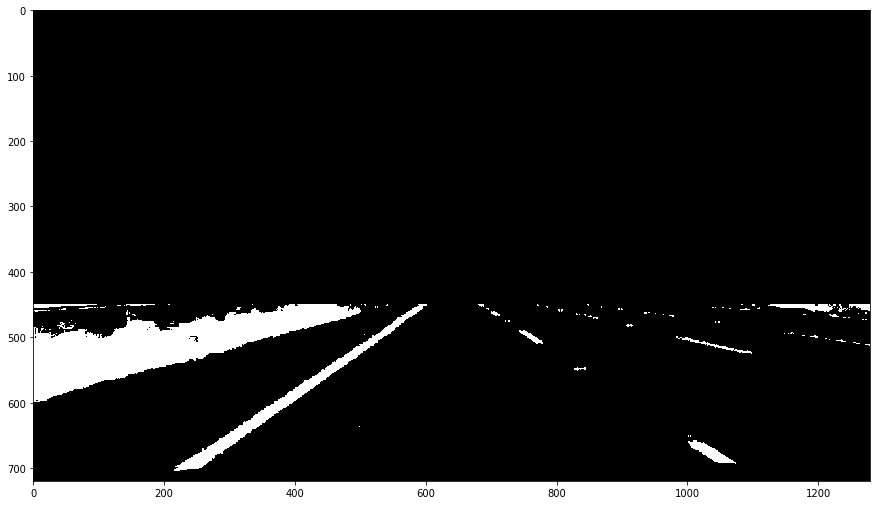

In [9]:
# Load test image
test_images = glob.glob('test_images/*.jpg')
image = undist_(cv2.imread(test_images[7]))
image = pipline_(image)
plt.figure(figsize=(15,12))
plt.imshow(image, cmap='gray');

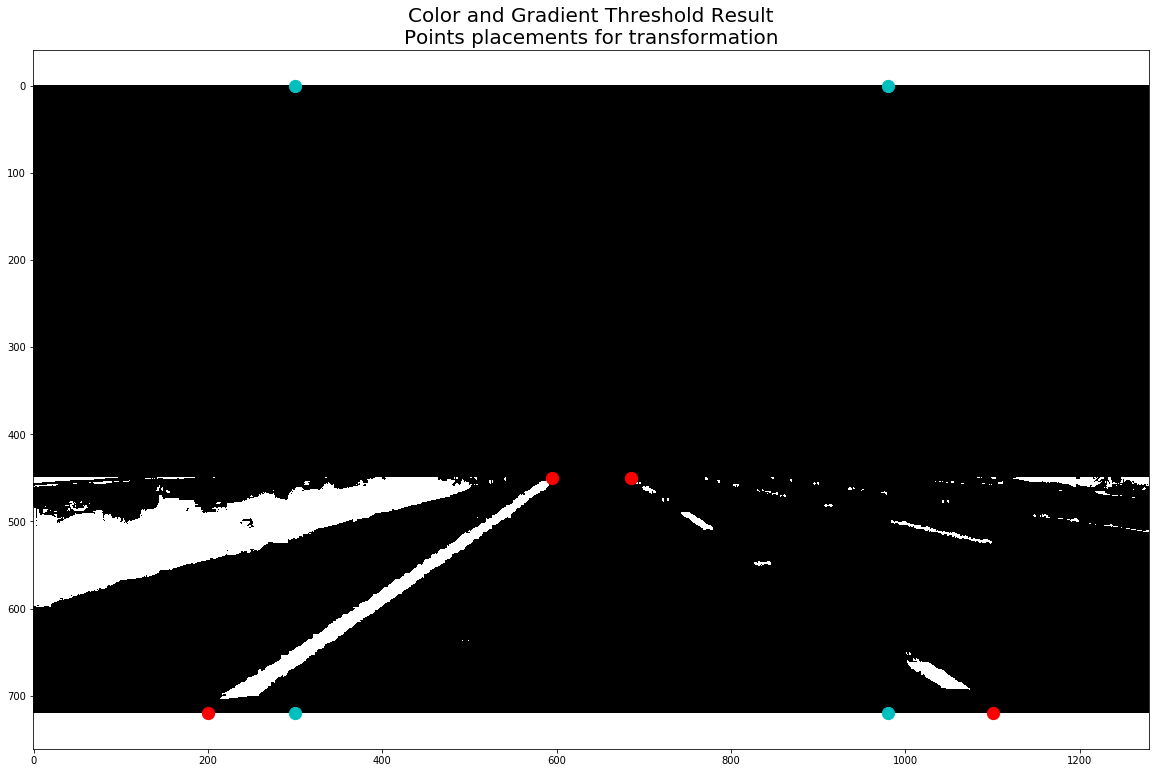

In [10]:
# Load test image
%matplotlib inline
test_images = glob.glob('test_images/*.jpg')
image = cv2.imread(test_images[7])
# Color and Gradient Threshold and Image distortion processing
image = undist_(image)
result = pipline_(image)
# Plot the result
plt.figure(figsize=(20,20))
plt.imshow(result, cmap='gray')
plt.title('Color and Gradient Threshold Result\nPoints placements for transformation', fontsize=20)
# Transformation dots
plt.scatter(200, 720, s=150, c='r', marker='o')
plt.scatter(1100,720, s=150, c='r', marker='o')
plt.scatter(595, 450, s=150, c='r', marker='o')
plt.scatter(685, 450, s=150, c='r', marker='o')
# Destination dots
plt.scatter(300, 720, s=150, c='c', marker='o')
plt.scatter(980,720,  s=150, c='c', marker='o')
plt.scatter(300, 0,   s=150, c='c', marker='o')
plt.scatter(980, 0,   s=150, c='c', marker='o');

### Perspective transformation
#### The image and selted dots to test transformation are shown in the picture above

In [11]:
# Transformation dots
src = np.float32(
    [[200, 720],
     [1100,720],
     [595, 450],
     [685, 450]])
# Destination dots
dst = np.float32(
    [[300, 720],
     [980, 720],
     [300, 0],
     [980,0]])
   
img_size = (image.shape[1], image.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def PerspTranform_(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
def PerspTranformInv_(img):
    return cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
# Test Perspective transformation
warped = PerspTranform_(result)
warpedInv = PerspTranformInv_(warped)

# Test on curve road
image_curv = cv2.imread(test_images[7])
image_curv = undist_(image_curv)
result_curv = pipline_(image_curv)
warped_curv = PerspTranform_(result_curv)
warped_Curv_Inv = PerspTranformInv_(warped_curv)

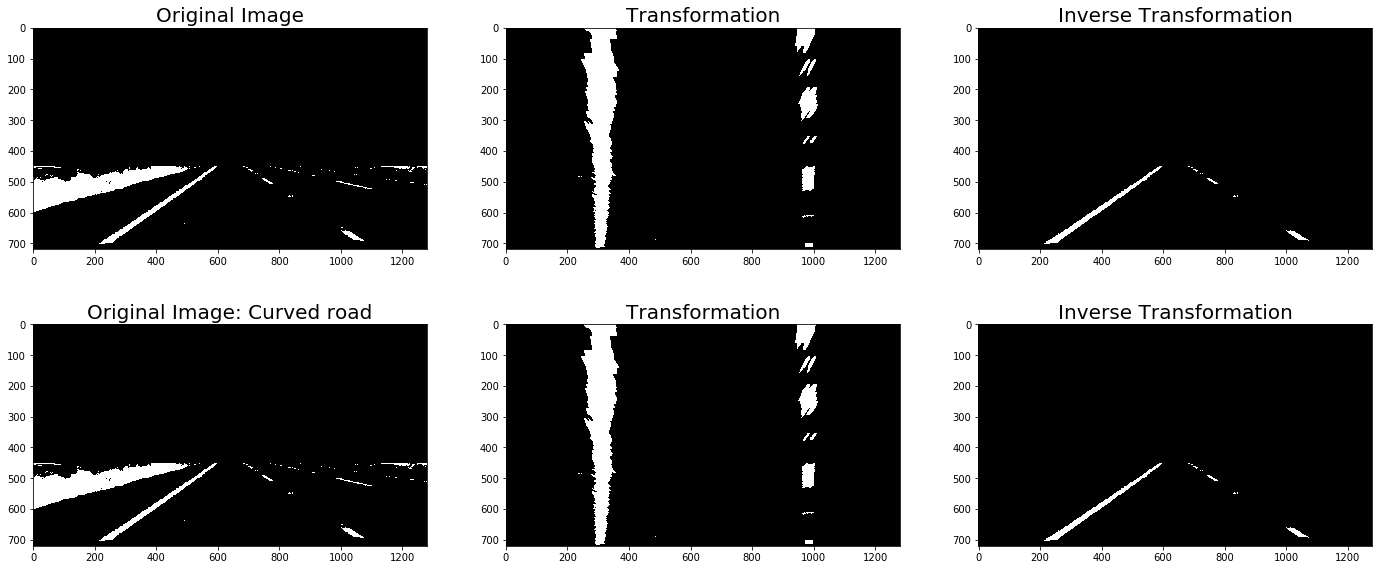

In [12]:
%matplotlib inline
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 10))
ax1.imshow(result, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Transformation', fontsize=20)
ax3.imshow(warpedInv, cmap='gray')
ax3.set_title('Inverse Transformation', fontsize=20)

ax4.imshow(result_curv, cmap='gray')
ax4.set_title('Original Image: Curved road', fontsize=20)
ax5.imshow(warped_curv, cmap='gray')
ax5.set_title('Transformation', fontsize=20)
ax6.imshow(warped_Curv_Inv, cmap='gray')
ax6.set_title('Inverse Transformation', fontsize=20);

In [13]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching
number_of_iteration = image.shape[0]//window_height
averaging_limit = 20
max_threshold = 300
print("Number of iterations: {}".format(number_of_iteration))

Number of iterations: 9


In [14]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width=window_width, window_height=window_height, margin=margin):
    averaging = averaging_limit
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(5*image.shape[0]/6):,:int(image.shape[1]/2)], axis=0)
    #l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    l_center = int(np.median(np.argpartition(np.convolve(window,l_sum), -averaging)[-averaging:]))-window_width/2
    r_sum = np.sum(image[int(5*image.shape[0]/6):,int(image.shape[1]/2):], axis=0)
    #r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    r_center = int(np.median(np.argpartition(np.convolve(window,r_sum), -averaging)[-averaging:]))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        averaging = averaging_limit
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_conv_max = max(conv_signal[l_min_index:l_max_index], default=0)
        
        #l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_conv_max = max(conv_signal[r_min_index:r_max_index], default=0)
        
        #r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if (l_conv_max >= max_threshold) and (r_conv_max >= max_threshold):
            l_center = int(np.median(np.argpartition(conv_signal[l_min_index:l_max_index], -averaging)[-averaging:]))+l_min_index-offset
            try:
                r_center = int(np.median(np.argpartition(conv_signal[r_min_index:r_max_index],-averaging)[-averaging:]))+r_min_index-offset
            except:
                averaging = int(averaging_limit/2)
                r_center = int(np.median(np.argpartition(conv_signal[r_min_index:r_max_index],-averaging)[-averaging:]))+r_min_index-offset
        elif (l_conv_max < max_threshold) and (r_conv_max < max_threshold):
            r_center = r_center
            l_center = l_center
        elif l_conv_max >= r_conv_max:
            shift = r_center - l_center
            l_center = int(np.median(np.argpartition(conv_signal[l_min_index:l_max_index], -averaging)[-averaging:]))+l_min_index-offset
            r_center = l_center + shift
        elif l_conv_max < r_conv_max:
            shift = r_center - l_center
            try:
                r_center = int(np.median(np.argpartition(conv_signal[r_min_index:r_max_index],-averaging)[-averaging:]))+r_min_index-offset
            except:
                r_center = r_center
            l_center = r_center - shift
        else:
            r_center = r_center
            l_center = l_center
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [15]:
# To draw windowfitting
def WindowFittingDraw(img, window_width = window_width, window_height = window_height, margin = margin):
    window_centroids = find_window_centroids(img, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img)
        r_points = np.zeros_like(img)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((img,img,img)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((img,img,img)),np.uint8)
    return output

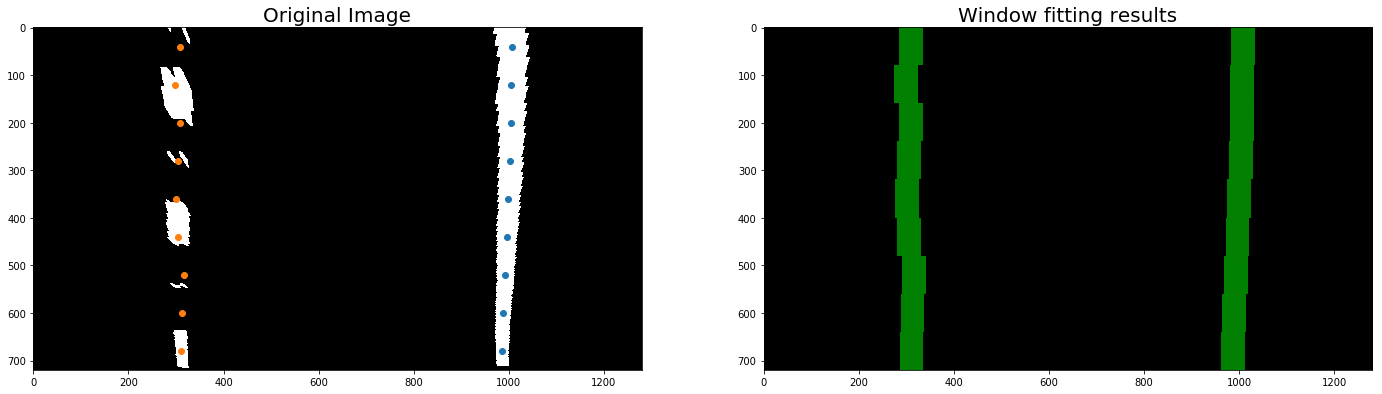

In [16]:
# Display the final results
%matplotlib inline

image = cv2.imread(test_images[2])
test_image = PerspTranform_(pipline_(undist_(image)))
test1 = WindowFittingDraw(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
ax1.imshow(test_image, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(test1)
ax2.set_title('Window fitting results', fontsize=20)

centroids = find_window_centroids(test_image, 50, 80, 50)

cent_L = np.array(centroids).T[0]
cent_R = np.array(centroids).T[1]
x = np.linspace(720, 0, len(centroids), endpoint=False)
ax1.scatter(cent_R,x-window_height/2)
ax1.scatter(cent_L,x-window_height/2);
#centroids

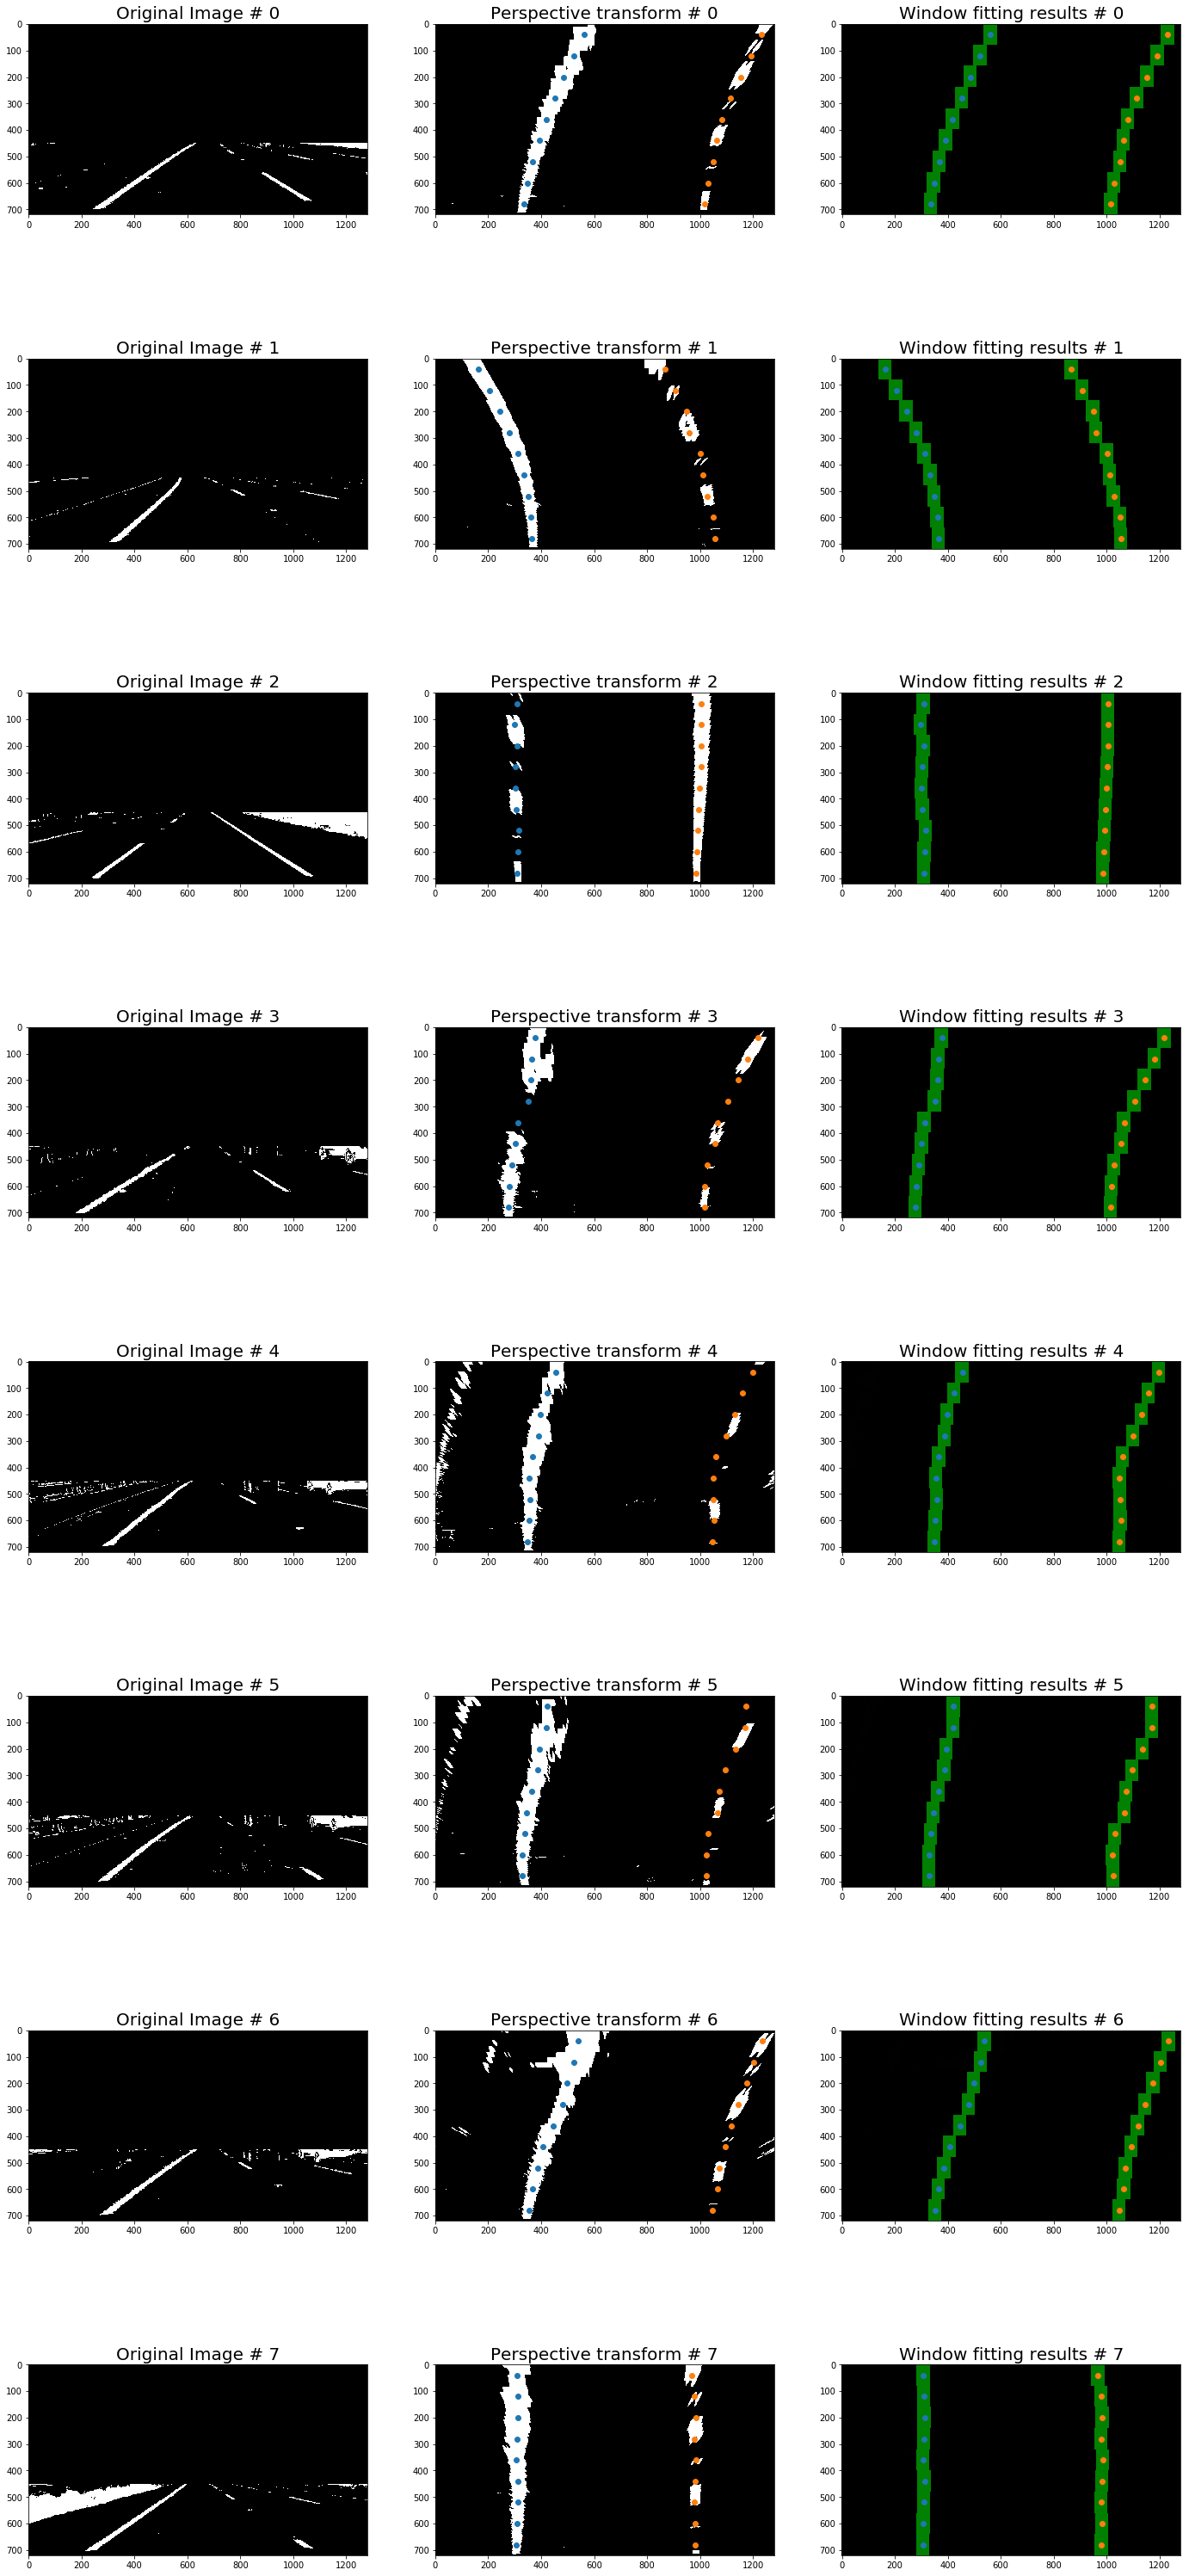

In [17]:
image_number = len(test_images)
x = np.linspace(720, 0, number_of_iteration, endpoint=False)
f, axarr = plt.subplots(8, 3, figsize=(24, 56))
for i in range(image_number):
    image = cv2.imread(test_images[i])
    
    result_ColGrad = pipline_(undist_(image))
    result_Per = PerspTranform_(result_ColGrad)
    result_Win = WindowFittingDraw(result_Per)
    centroids = find_window_centroids(result_Per)
    cent_L = np.array(centroids).T[0]
    cent_R = np.array(centroids).T[1]
    
    axarr[i,0].imshow(result_ColGrad, cmap='gray')
    axarr[i,0].set_title('Original Image # {}'.format(i), fontsize=20)
    axarr[i,1].imshow(result_Per, cmap='gray')
    axarr[i,1].scatter(cent_L,x-window_height/2)
    axarr[i,1].scatter(cent_R,x-window_height/2)
    axarr[i,1].set_title('Perspective transform # {}'.format(i), fontsize=20)
    axarr[i,2].imshow(result_Win)
    axarr[i,2].scatter(cent_L,x-window_height/2)
    axarr[i,2].scatter(cent_R,x-window_height/2)
    axarr[i,2].set_title('Window fitting results # {}'.format(i), fontsize=20);

677.0
705.0


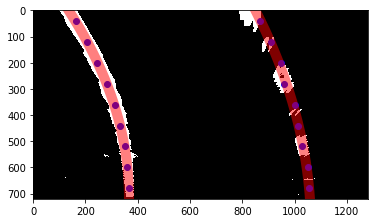

In [18]:
image = cv2.imread(test_images[1])
x = np.linspace(720, 0, number_of_iteration, endpoint=False) - window_height/2
plotx = np.linspace(0, image.shape[0]-1, image.shape[0])

result_ColGrad = pipline_(undist_(image))
result_Per = PerspTranform_(result_ColGrad)
centroids = find_window_centroids(result_Per)

cent_L = np.array(centroids).T[0]
cent_R = np.array(centroids).T[1]

left_fit = np.polyfit(x, cent_L, 2)
right_fit = np.polyfit(x, cent_R, 2)

left_fitx  = left_fit[0]*plotx**2 + left_fit[1]*plotx + left_fit[2]
right_fitx = right_fit[0]*plotx**2 + right_fit[1]*plotx + right_fit[2]

plt.imshow(result_Per, cmap='gray')
plt.scatter(cent_L, x, color = 'blue')
plt.scatter(cent_R, x, color = 'blue')
plt.plot(left_fitx,  plotx, color='red', linewidth=10.0, alpha= 0.5)
plt.plot(right_fitx, plotx, color='red', linewidth=10.0, alpha= 0.5)
plt.xlim(0, 1280)
plt.ylim(720, 0);


print(np.min(cent_R- cent_L))
print(np.max(cent_R- cent_L))

### We can calculate the radius of curvature in pixels as follows:

In [19]:
# Radius of curvature calculation - in pixels
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(plotx)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(round(left_curverad,1), round(right_curverad,1))

1106.2 1649.2


### We can calculate the radius of curvature in meters as follows.
Assume that the lane is about 30 meters long and 3.7 meters wide

In [20]:
# Conversions in x and y from pixels space to meters
y_eval = np.max(plotx)/2
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(x*ym_per_pix, cent_L*xm_per_pix, 2)
right_fit_cr =np.polyfit(x*ym_per_pix, cent_R*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1]) **2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad =((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(round(left_curverad,1), round(right_curverad,1))

364.2 538.8


### Drawing

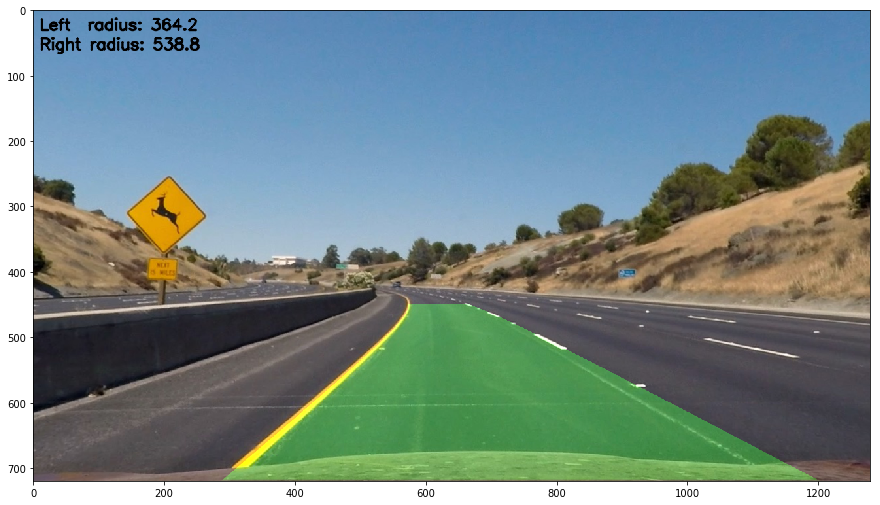

In [21]:
# Create an image to draw the lines on
warped = result_ColGrad

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, plotx]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plotx])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_(image), 1, newwarp, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result,'Left  radius: ' + str(round(left_curverad, 1)),(10,30), font, 0.8,(0,0,0),2,cv2.LINE_AA)
cv2.putText(result,'Right radius: ' + str(round(right_curverad,1)),(10,60), font, 0.8,(0,0,0),2,cv2.LINE_AA)
plt.figure(figsize=(15,12))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB));

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
# to save poly coeffinients
r_coef = []
l_coef = []
# to save poly coeffinients in meters
r_coef_m = []
l_coef_m = []

cent_L_previous = None
cent_R_previous = None

In [24]:
# To average last 5 poly coefficients
x = np.linspace(720, 0, number_of_iteration, endpoint=False) - window_height/2
y_eval = int(np.max(plotx)/2)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def avgPolyCoef(cent, side = 'l'):
    global r_coef
    global l_coef
    global r_coef_m
    global l_coef_m
    
    item = np.polyfit(x, cent, 2)
     
    item_m = np.polyfit(x*ym_per_pix, cent*xm_per_pix, 2)
    if side == 'l':
        a  = l_coef
        a_m = l_coef_m
    elif side == 'r':
        a  = r_coef
        a_m = r_coef_m
    else:
        print('Error')
        return 0
    if len(a) == 5:
        a.pop(0)
        a_m.pop(0)
        a.append(item)
        a_m.append(item_m)
    else:
        a.append(item)
        a_m.append(item_m)
    return np.mean(np.array(a),axis=0)
# If line shifted more than 150 px, then use previos observation
def cent_check(cent_L, cent_R):
    global cent_L_previous
    global cent_R_previous
    
    if (cent_L_previous == None) or (cent_R_previous == None):
        cent_L_previous = cent_L.copy()
        cent_R_previous = cent_R.copy()
    else:
        L = np.max(np.abs(cent_L_previous - cent_L))
        if L > 150:
            cent_L = cent_L_previous.copy()
        else:
            cent_L_previous = cent_L.copy()
        R = np.max(np.abs(cent_R_previous - cent_R))
        if R > 150:
            cent_R = cent_R_previous.copy()
        else:
            cent_R_previous = cent_R.copy()
    return cent_L, cent_R

# Radius calculation
# Function input - polynom coeeficients
def radius_():
    global r_coef_m
    global l_coef_m
    fit_r = np.mean(np.array(r_coef_m),axis=0)
    fit_l = np.mean(np.array(l_coef_m),axis=0)
    rad_r = np.round(((1 + (2*fit_r[0] *y_eval*ym_per_pix + fit_r[1]) **2)**1.5) / np.absolute(2*fit_r[0]))
    rad_l = np.round(((1 + (2*fit_l[0] *y_eval*ym_per_pix + fit_l[1]) **2)**1.5) / np.absolute(2*fit_l[0]))
    return np.round(rad_l), np.round(rad_r)

In [25]:
x = np.linspace(720, 0, number_of_iteration, endpoint=False) - window_height/2

plotx = np.linspace(0, image.shape[0]-1, image.shape[0])

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    warped = pipline_(undist_(image))
    result_Per = PerspTranform_(warped)
    centroids = find_window_centroids(result_Per)

    cent_L = np.array(centroids).T[0]
    cent_R = np.array(centroids).T[1]
    cent_L, cent_R = cent_check(cent_L, cent_R)
    
    left_fit = avgPolyCoef(cent_L, 'l')
    right_fit = avgPolyCoef(cent_R, 'r')
    
    left_fitx  = left_fit[0]*plotx**2 + left_fit[1]*plotx + left_fit[2]
    right_fitx = right_fit[0]*plotx**2 + right_fit[1]*plotx + right_fit[2]
    
    center = np.round((1280 - (left_fitx[-1]+right_fitx[-1]))/2)
    l_rad, r_rad = radius_()

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, plotx]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plotx])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_(image), 1, newwarp, 0.3, 0)
    cv2.putText(result,'Center: ' + str(center),(10,30), font, 0.8,(0,0,0),2,cv2.LINE_AA)
    cv2.putText(result,'Left  radius: ' + str(l_rad), (10,90), font, 0.8,(0,0,0),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius: ' + str(r_rad), (10,120), font, 0.8,(0,0,0),2,cv2.LINE_AA)
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

In [26]:
# to save poly coeffinients
r_coef = []
l_coef = []
# to save poly coeffinients in meters
r_coef_m = []
l_coef_m = []

cent_L_previous = None
cent_R_previous = None

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(27,29)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:41<00:00,  4.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 9min 12s, sys: 4.24 s, total: 9min 16s
Wall time: 5min 43s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))